<a href="https://colab.research.google.com/github/annika-fagerstrom/NumericalAnalysis/blob/main/Copy_of_Project_5_Singular_Value_Decomposition_and_Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Project 5 - Singular Value Decomposition and Image Processing

The Singular Value Decomposition (SVD) has many applications in pure mathematics, applied mathematics, and data science. A common theme of many applications of SVD is that for a matrix $A$, by using SVD, we can find a new matrix $A_k$ which is a good approximation of $A$, but the rank of $A_k$ is at most $k$. In general, a small rank matrix can be described with a lower number of entries; we can regard $A_k$ as a "compression" of $A$. 

The goal of this project is twofold. First of all, we investigate how to compress image data using the already implemented SVD calculation method. Secondly, we will make a code for one step of SVD calculation. 

#### 1. (25 pts) Two key steps on the diagonalization of a symmetric matrix (and hence on SVD) are Householder reduction and the QR method. Construct a method QRalgorithm(A, err) where $A$ is a symmetric tridiagonal matrix, err is a positive real number, and output is a list of eigenvalues of $A$. Let $A^{(k)}$ be the output of $k$-th iteration (See the notation in the lecture note) and let $e^{(k)}$ be the vector consisting of diagonal entries of $A^{(k)}$. Stop the iteration if either 
<ul>
    <li>$k = 1000$ or;</li>
    <li>$||e^{(k)} - e^{(k-1)}||_{\infty} < \mathrm{err}$.</li>
</ul>

#### Let $M$ be a $(10 \times 10)$ symmetric tridiagonal matrix such that $$M_{ij} = \begin{cases}11-i, & \mbox{if } i = j,\\1, & \mbox{if } i = j+1 \mbox{ or } i = j-1,\\0, & \mbox{otherwise}.\end{cases}$$
#### By using QRalgorithm(A, err), compute eigenvalues of $M$. Set $\mathrm{err} = 10^{-5}$. 

In [ ]:
import numpy as np

def QRAlgorithm(A, err):
    """
    This function executes the QR Method. 
    
    Parts of this are modified from Algorithm 9.6 in the textbook, 
    but we do not include any of the "SHIFT" calculations.
    
    Inputs:
    - A (numpy array) : a symmetric, tridiagonal matrix 
    - err (float): error tolerance
    
    Outputs: 
    - list of eigenvalues
    """
    
    #initialize list of eigenvalues
    lambdas = []
    
    #compute dimensions of the matrix
    dims = np.shape(A)
    n = dims[0]
    
    #a and be will be lists of lists
    #note we initialize these these lists with None in the 0th position,
    # so the indexing matches the indexing in the book
    a = [None]
    b = [None]
    
    #initialize the a_0 and b_0 lists
    a_0 = [None] + [ A[i][i] for i in range(n) ]
    b_0 = [None,None] + [ A[i][i+1] for i in range(n-1) ]
    
    a.append(a_0)
    b.append(b_0)
    
    k = 1
    
    #the maximum number of iterations is 1000
    while k < 1000:
        
        #calculate whether we meet the error tolerance
        #this chunk of code replaces steps 3 and 4 in the textbook
        if k > 1:
            error_list = [abs(a[k][i] - a[k-1][i]) for i in range(1,n+1)]
            max_error = max(error_list)
            
            if max_error < err:
                lambdas = a[k][1:]
                return lambdas
        
              
      
        d = a[k]
        #initialize a bunch of blank lists for computations
        x = [None for i in range(n+1)]
        y = x.copy()
        z = x.copy()
        c = x.copy()
        sigma = x.copy()
        q = x.copy()
        r = x.copy()
        
        #Compute R^(k)
        x[1] = d[1]
        y[1] = b[k][2] #TODO: this line confusing in text
        
        for j in range(2,n+1):
            z[j-1] = ( (x[j-1])**2 + (b[k][j])**2)**(1/2)
            
            c[j] = x[j-1] / z[j-1]
            
            sigma[j] = b[k][j] / z[j-1]
            
            q[j-1] = c[j]*y[j-1] + sigma[j]*d[j] #TODO: replaced s with sigma
            
            x[j] = -sigma[j]*y[j-1] + c[j]*d[j]
            
            if j != n:
                r[j-1] = sigma[j]*b[k][j+1]
                y[j] = c[j]*b[k][j+1]
        
        #initialize the next lists of approximations
        k_succ = [None for i in range(n+1)]
        a.append(k_succ)
        b.append(k_succ.copy())
        
        #compute A^(k+1)
        z[n] = x[n]
        a[k+1][1] = sigma[2]*q[1] + c[2]*z[1]
        b[k+1][2] = sigma[2]*z[2]

        for j in range(2,n):
            a[k+1][j] = sigma[j+1]*q[j] + c[j]*c[j+1]*z[j]
            b[k+1][j+1] = sigma[j+1]*z[j+1]
        a[k+1][n] = c[n]*z[n]
        
        #continute iteration
        k += 1
    
    #Step 20
    print('Maximum number of iterations exceeded')

#create the matrix 10x10 matrix M
M = np.zeros((10,10))

for i in range(10):
    M[i][i] = 11 - (i+1)
    if i > 0:
        M[i][i-1] = 1
    if i < 9:
        M[i][i+1] = 1

err = 1e-5
        
eigenvals = QRAlgorithm(M,err)
print(eigenvals)

[10.746188123339987, 9.210648885259063, 8.038946941167087, 7.003973873481035, 6.0002244882298506, 4.999783392626266, 3.9960482417836567, 2.9610588843212855, 1.789321352695084, 0.2538058170966782]


From now on, we will discuss image processing with Python. For simplicity, we are going to use a grayscale (black and white) image only. Below is how to convert a grayscale image to a python matrix. Matplotlib can only read the .png file natively. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

sloth_img = plt.imread('sloth_gray.png') 
sloth_img_array = sloth_img[:,:,0] 
# These two lines read 'sloth_gray.png' and record it as an array.

rand_array = np.random.uniform(low=0, high=1, size=(480,360))
print(rand_array)

FileNotFoundError: ignored

A matrix can be converted to a grayscale image, like the following.

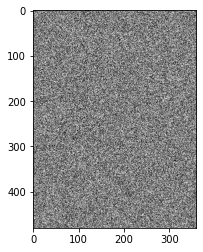

In [ ]:
new_img = np.ndarray((480,360,3),dtype=float)

for i in range(3):
    new_img[:,:,i] = rand_array
# This part makes a multi-dimensional array, which can be understood as an image.
  
plt.imshow(new_img)
plt.show()

In the above code, <b>sloth_img_array</b> is a matrix. Thus we can compute its SVD and use it to do some image processing. 

For a matrix $A$, <b>svd</b> method in the linear algebra module can be used to calculate its SVD. The output is a triplet of data $U$, $D$, and $V^t$, where $U$ and $V^t$ are orthogonal matrices and $D$ is a list of singular values of $A$ (not a diagonal matrix!). So if we denote $S$ as the diagonal matrix whose diagonal entries are numbers on $D$, then $A = USV^t$. 

In [ ]:
A = np.array([[1,0,1],[0,1,0],[0,1,1],[0,1,0],[1,1,0]])
U, D, Vt = la.svd(A, full_matrices = True)
print("U=", U)
print("D=", D)
print("V^t=", Vt)

U= [[-3.65148372e-01  8.16496581e-01  5.70180832e-16  1.18391207e-01
  -4.31258069e-01]
 [-3.65148372e-01 -4.08248290e-01 -3.36834237e-16 -5.63487672e-01
  -6.18451004e-01]
 [-5.47722558e-01 -2.49196703e-16  7.07106781e-01 -1.18391207e-01
   4.31258069e-01]
 [-3.65148372e-01 -4.08248290e-01 -3.06929745e-16  8.00270086e-01
  -2.44065135e-01]
 [-5.47722558e-01  5.90601783e-16 -7.07106781e-01 -1.18391207e-01
   4.31258069e-01]]
D= [2.23606798 1.41421356 1.        ]
V^t= [[-4.08248290e-01 -8.16496581e-01 -4.08248290e-01]
 [ 5.77350269e-01 -5.77350269e-01  5.77350269e-01]
 [-7.07106781e-01 -3.98635418e-16  7.07106781e-01]]


#### 2. (15 pts) Construct a method SVDcompression(A, k) which performs
<ul>
    <li>Compute a SVD of $A$;</li>
    <li>Calculate $A_k = U_k \cdot S_k \cdot V_k^t$, where $U_k$ is the first $k$ columns of $U$, $S_k$ is the first $k$ rows and $k$ columns of $S$, and $V_k^t$ is the first $k$ rows of $V^t$;</li>
    <li>Convert $A_k$ as a grayscale image and show it.</li>
</ul>

In [ ]:
def SVDcompression(A,k):
  U, D, Vt = la.svd(A, full_matrices=True)
  n = len(D)

  #construct the diagonal matrix S
  S = np.zeros((n,n))
  for i in range(n):
    S[i][i] = D[i]

  #construct U_k, S_k, and V_k
  U_k = U[:,:k]
  S_k = S[:k,:k]
  Vt_k = Vt[:k,:]
  
  A_k = U_k @ S_k @ Vt_k

  dims = np.shape(A_k)
  
  A_img = np.ndarray((dims[0],dims[1],3),dtype=float)
  for i in range(3):
    A_img[:,:,i] = A_k
    
  plt.imshow(A_k)
  plt.show()  

#### 3. (10 pts) Prepare your favorite image file in a grayscale .png format. (A photo is better than computer graphics. I suggest using a picture smaller than $500 \times 500$.) Load the image file and plot the original image. Convert the image as a matrix $A$. Run SVDcompression(A,k) for $k = 1, 5, 10$, and $50$.

In [ ]:
#Run once! after directory is loaded, it will try and reload itself and create an error
!git clone https://github.com/annika-fagerstrom/DataMining.git images
from PIL import Image


Cloning into 'images'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [ ]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

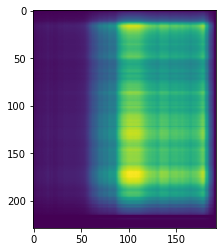

In [ ]:

kitten_img = plt.imread('images/cute-kitten-png-gray.png')
kitten_img_gray = np.mean(kitten_img, -1)
A = kitten_img[:,:,0]

SVDcompression(A,1)

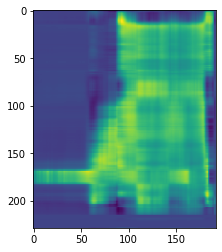

In [ ]:
SVDcompression(A,5)

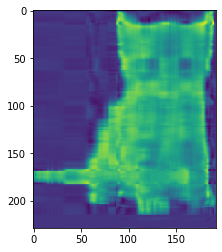

In [ ]:
SVDcompression(A,10)

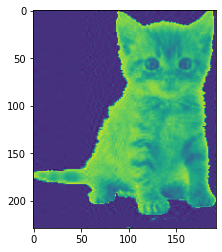

In [ ]:
SVDcompression(A,50)

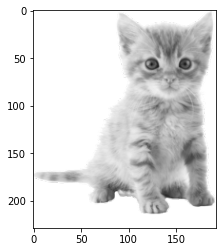

In [ ]:
plt.imshow(kitten_img)